In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

from tqdm import tqdm
import yaml

from scipy.stats import binned_statistic_2d
# import shap

from flash_ansr import get_path, ExpressionSpace
from flash_ansr.eval.utils import bootstrapped_metric_ci

In [2]:
N = 1000  # Some were run with 5000 oops, so we'll just use 1000 for consistency

In [3]:
def nan_false_statistic(X, statistic):
    X_copy = np.array(X)
    # Where X is nan, replace with False
    X_copy[np.isnan(X_copy)] = False
    return statistic(X_copy)

In [4]:
MODELS = [os.path.join('analysis_choices_v7.0', m) for m in os.listdir(get_path('results', 'evaluation', 'analysis_choices_v7.0'))]

In [5]:
MODELS_DESCRIPTION = {k: k.replace('v7.0_', '') for k in MODELS}

In [6]:
TEST_SETS = ['train', 'val', 'feynman', 'soose_nc', 'nguyen', 'pool_15']
TEST_SET_TITLES = {
    'train': 'Train',
    'val': 'Val',
    'feynman': 'Feynman',
    'soose_nc': 'S.-NC',
    'nguyen': 'Nguyen',
    'pool_15': 'Pool 15',
}

In [7]:
configs = {}

for model in MODELS:
    with open(get_path(f'configs/{model}/evaluation.yaml'), 'r') as f:
        configs[model] = yaml.safe_load(f)

In [8]:
test_sets = {model: [path.replace('.pickle', '') for path in os.listdir(get_path(f'results/evaluation/{model}'))] for model in MODELS}

for model, model_test_sets in test_sets.items():
    # Reorder the test sets as follows: train, val, feynman, soose_nc, nguyen
    for i, s in enumerate(TEST_SETS):
        if s in model_test_sets:
            model_test_sets.remove(s)
            model_test_sets.insert(i, s)

In [9]:
results = {}

for model, model_test_sets in test_sets.items():
    results[model] = {test_set: {'path': get_path(f'results/evaluation/{model}/{test_set}.pickle')} for test_set in model_test_sets}

In [10]:
remove_invalid = []

for model, model_results in results.items():
    pbar = tqdm(model_results.items(), desc=f'Loading {model} results')
    for test_set, test_set_results in pbar:
        pbar.set_postfix_str(test_set)
        with open(test_set_results['path'], 'rb') as f:
            test_set_results['data'] = pickle.load(f)
            
            for k, v in test_set_results['data'].items():
                test_set_results['data'][k] = v[:N]

            columns_to_rename = set()
            for k, v in test_set_results['data'].items():
                try:
                    test_set_results['data'][k] = np.array(v)
                except ValueError:
                    pass

                if '_free_' in k:
                    columns_to_rename.add(k)

            for k in columns_to_rename:
                test_set_results['data'][k.replace('_free_', '_')] = test_set_results['data'][k]
                del test_set_results['data'][k]

            keys_to_remove = [k for k in test_set_results['data'].keys() if 'residuals' in k]
            keys_to_remove.extend(['x', 'y'])

            for k in keys_to_remove:
                del test_set_results['data'][k]

Loading analysis_choices_v7.0/v7.0_2-choices results: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s, pool_15] 
Loading analysis_choices_v7.0/v7.0_4-choices results: 100%|██████████| 4/4 [00:02<00:00,  1.98it/s, pool_15] 
Loading analysis_choices_v7.0/v7.0_32-choices results: 100%|██████████| 4/4 [00:13<00:00,  3.37s/it, pool_15] 
Loading analysis_choices_v7.0/v7.0_128-choices results: 100%|██████████| 4/4 [00:52<00:00, 13.00s/it, pool_15] 
Loading analysis_choices_v7.0/v7.0_256-choices results: 100%|██████████| 4/4 [01:36<00:00, 24.22s/it, pool_15] 
Loading analysis_choices_v7.0/v7.0_1-choices results: 100%|██████████| 4/4 [00:00<00:00,  6.82it/s, pool_15] 
Loading analysis_choices_v7.0/v7.0_16-choices results: 100%|██████████| 4/4 [00:08<00:00,  2.06s/it, pool_15] 
Loading analysis_choices_v7.0/v7.0_1024-choices results: 100%|██████████| 4/4 [05:16<00:00, 79.00s/it, pool_15] 
Loading analysis_choices_v7.0/v7.0_512-choices results: 100%|██████████| 4/4 [02:44<00:00, 41.16s/it, pool_15] 

In [11]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    n_restarts = configs[model].get('n_restarts', 1)
    # Pad the beams to their maximum length
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']

        if model == 'pysr':
            results[model][test_set]['data']['wall_time'] = data['fit_time']
            results[model][test_set]['data']['sys_time'] = data['fit_time'] * 32  # 32 cores
        
        elif model == 'nesymres-100M':
            results[model][test_set]['data']['wall_time'] = data['fit_time']
            results[model][test_set]['data']['sys_time'] = data['fit_time']

        else:
            results[model][test_set]['data']['wall_time'] = data['fit_time']
            results[model][test_set]['data']['sys_time'] = data['fit_time']

100%|██████████| 4/4 [00:00<00:00, 79137.81it/s]


In [12]:
# Replace 'beam_val_' with 'val_beam' in columns where 'beam_val_' is present
for model, model_results in results.items():
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']

        columns_before = set(data.keys())
        changed_columns = []
        for k in columns_before:
            if 'beam_val_' in k:
                data[k.replace('beam_val_', 'val_beam_')] = data[k]
                changed_columns.append(k)

        for k in changed_columns:
            del data[k]

100%|██████████| 4/4 [00:00<00:00, 11932.59it/s]


In [13]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    # Pad the beams to their maximum length
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']

        results[model][test_set]['data']['length_target'] = np.array([len(data['input_ids'][i]) for i in range(len(data['input_ids']))])
        
        for j in range(beam_width):
            results[model][test_set]['data'][f'length_beam_{j + 1}'] = np.array([len(data[f'free_beam_{j + 1}'][i]) for i in range(len(data[f'free_beam_{j + 1}']))])

            if f'residuals_beam_{j + 1}' not in data:
                continue
            results[model][test_set]['data'][f'L_inf_beam_{j + 1}'] = np.array([(np.nanmax(np.abs(data[f'residuals_beam_{j + 1}'][i])) if data[f'residuals_beam_{j + 1}'][i] is not None else np.nan) for i in range(len(data[f'residuals_beam_{j + 1}']))])
        
        if '_beam_1' not in data:
            continue

        max_length = max(max([len(beam) for beam in data[f'_beam_{j + 1}']]) for j in range(beam_width))

        for j in range(beam_width):
            padded_beam = [beam + [0] * (max_length - len(beam)) for beam in data[f'_beam_{j + 1}']]
            data[f'_beam_{j + 1}'] = np.array(padded_beam)


100%|██████████| 4/4 [00:00<00:00, 2360.00it/s]


In [14]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    for test_set, test_set_results in tqdm(model_results.items()):
        valid = True
        data = test_set_results['data']

        beam_columns = [k.replace('_beam_1', '') for k in data.keys() if k.endswith(f'beam_1') and not 'residuals' in k and not 'free' in k]

        # Create new columns with metrics of the best beam (by mse_{generation_type}_beam_{i}) and store it as {metric}_{generation_type}_best_beam
        # Create new columns
        for column in beam_columns:
            if isinstance(data[column + '_beam_1'][0], np.ndarray):
                data[column + '_best_beam'] = np.nan * np.ones_like(data[column + '_beam_1'])
            else:
                data[column + '_best_beam'] = np.nan * np.ones(len(data[column + '_beam_1']))

        data['best_beam'] = np.nan * np.ones(len(data['mse_beam_1']))

        # For each instance, find the best beam by mse
        for i in range(len(data['mse_beam_1'])):
            mse_list = np.array([data[f'mse_beam_{j}'][i] for j in range(1, beam_width+1) if f'mse_beam_{j}' in data.keys()])
            if np.all(np.isnan(mse_list)):
                continue
            best_beam = np.nanargmin([data[f'mse_beam_{j}'][i] for j in range(1, beam_width+1) if f'mse_beam_{j}' in data.keys()]) + 1
            data['best_beam'][i] = best_beam
            for column in beam_columns:
                data[column + '_best_beam'][i] = data[column + f'_beam_{best_beam}'][i]

100%|██████████| 4/4 [00:00<00:00, 61.05it/s]


In [15]:
# Design features
for model, model_results in results.items():
    for test_set, test_set_results in model_results.items():
        for maybe_val in ['', '_val']:
            test_set_results['data'][f'is_finite{maybe_val}'] = np.array([np.isfinite(r2) for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])

            test_set_results['data'][f'FVU-eps_accuracy{maybe_val}'] = np.array([(1 - r2) <= np.finfo(np.float32).eps for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])

            test_set_results['data'][f'fvu{maybe_val}'] = np.array([1 - r2 for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])
            test_set_results['data'][f'log_fvu{maybe_val}'] = np.array([np.log10(max(1 - r2, np.finfo(np.float32).eps)) for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])

            test_set_results['data'][f'fvu_not_epsilon{maybe_val}'] = np.copy(test_set_results['data'][f'fvu{maybe_val}'])
            test_set_results['data'][f'fvu_not_epsilon{maybe_val}'][test_set_results['data'][f'FVU-eps_accuracy{maybe_val}']] = np.nan

            test_set_results['data'][f'log_fvu_not_epsilon{maybe_val}'] = np.array([np.log10(fvu) for fvu in test_set_results['data'][f'fvu_not_epsilon{maybe_val}']])

        if 'perplexity' in test_set_results['data']:
            test_set_results['data']['log_ppl'] = [np.log10(ppl) for ppl in test_set_results['data']['perplexity']]
        else:
            test_set_results['data']['log_ppl'] = [np.nan] * len(test_set_results['data']['r2_best_beam'])

In [ ]:
# Find the intersection of the columns of all the dataframes
compare_columns = set.union(*[set(test_set_results['data'].keys()) for model_results in results.values() for test_set_results in model_results.values()])
compare_columns = compare_columns - {'x', 'y', 'y_noisy', 'x_val', 'y_val', 'y_noisy_val', 'constants', 'input_ids', 'labels', 'residuals_beam_1', 'n_support', 'free_best_beam'}
compare_columns = compare_columns - {c for c in compare_columns if any(c.endswith(f'_{i}') or 'free' in c for i in range(1, 1024))}
# compare_columns = compare_columns.union({'perplexity', 'precision_best_beam', 'recall_best_beam', 'meteor_best_beam', 'edit_distance'})
compare_columns

{'log_prob_beam219',
 'rouge2_fmeasure_beam_1024',
 'log_prob_beam307',
 'log_prob_beam265',
 'log_prob_beam437',
 'log_prob_beam152',
 'log_prob_beam435',
 'log_prob_beam775',
 'log_prob_beam762',
 'log_prob_beam869',
 'log_prob_beam25',
 'log_prob_beam998',
 'log_prob_beam436',
 'log_prob_beam562',
 'log_prob_beam649',
 'log_prob_beam123',
 'rouge2_fmeasure_best_beam',
 'log_prob_beam725',
 'log_prob_beam537',
 'log_prob_beam452',
 'log_prob_beam441',
 'log_prob_beam653',
 'log_prob_beam516',
 'log_prob_beam47',
 'log_prob_beam985',
 'log_prob_beam66',
 'log_prob_beam700',
 'log_prob_beam304',
 'log_prob_beam654',
 'log_prob_beam43',
 'log_prob_beam255',
 'log_prob_beam334',
 'log_prob_beam795',
 'log_prob_beam622',
 'log_prob_beam487',
 'log_prob_beam229',
 'log_prob_beam750',
 'log_prob_beam806',
 'log_prob_beam139',
 'log_prob_beam862',
 'log_prob_beam40',
 'log_prob_beam356',
 'log_prob_beam742',
 'log_prob_beam132',
 'log_prob_beam197',
 'log_prob_beam941',
 'log_prob_beam801',


In [17]:
array_dfs = {
    model: {
        test_set:
        pd.DataFrame({k: v for k, v in test_set_results['data'].items() if k in compare_columns}).astype(float)
            for test_set, test_set_results in model_results.items()}
            for model, model_results in results.items()}

In [18]:
compare_columns_defaults = {
    'FVU-eps_accuracy': 0,
    'perplexity': np.inf,
    'log_ppl': np.inf,
    'precision_best_beam': 0,
    'recall_best_beam': 0,
    'L_inf_best_beam': np.inf,
    'NSRTS_accuracy_close_best_beam': 0,
    'NSRTS_accuracy_r2_best_beam': 0,
    'NSRTS_accuracy_close_val_best_beam': 0,
    'NSRTS_accuracy_r2_val_best_beam': 0,
    'accuracy_best_beam': 0,
    'bleu_best_beam': 0,
    'edit_distance_best_beam': np.inf,
    'f1_score_best_beam': 0,
    'fvu': np.inf,
    'log_fvu': np.inf,
    'fvu_not_epsilon': np.inf,
    'log_fvu_not_epsilon': np.inf,
    'log_ppl': np.inf,
    'meteor_best_beam': 0,
    'mse_best_beam': np.inf,
    'mse_val_best_beam': np.inf,
    'perplexity': np.inf,
    'precision_best_beam': 0,
    'r2_best_beam': -np.inf,
    'r2_val_best_beam': -np.inf,
    'recall_best_beam': 0,
    'reciprocal_rank': 0,
    'rouge1_fmeasure_best_beam': 0,
    'rouge1_precision_best_beam': 0,
    'rouge1_recall_best_beam': 0,
    'rouge2_fmeasure_best_beam': 0,
    'rouge2_precision_best_beam': 0,
    'rouge2_recall_best_beam': 0,
    'rougeL_fmeasure_best_beam': 0,
    'rougeL_precision_best_beam': 0,
    'rougeL_recall_best_beam': 0,
    'structural_accuracy_best_beam': 0,
    'tree_edit_distance_best_beam': np.inf,
    'wall_time': np.inf,
    'sys_time': np.inf,
    'is_finite': 0,
}

In [19]:
from functools import partial

In [20]:
def naninfmean(x):
    return np.nanmean(np.array(x)[np.isfinite(x)])

# Per Dataset

In [21]:
summaries = {model: {test_set: {column: {} for column in compare_columns} for test_set, df in model_dfs.items()} for model, model_dfs in array_dfs.items()}
metrics = None

N_BOOTSTRAPS = 1_000

for model, model_dfs in array_dfs.items():
    for test_set, df in model_dfs.items():
        for column in tqdm(compare_columns, desc=f'{model} {test_set}'):
            sub_metrics = ['mean', 'median', '2.5p', '97.5p']
            sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]
            if column in df.columns:
                data = df[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
                summaries[model][test_set][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}
            else:
                summaries[model][test_set][column] = {k: (np.nan, ) * 3 for k in sub_metrics}

            if metrics is None:
                metrics = summaries[model][test_set][column].keys()

analysis_choices_v7.0/v7.0_2-choices feynman:  67%|██████▋   | 738/1097 [00:03<00:01, 207.94it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
analysis_choices_v7.0/v7.0_1-choices feynman:  15%|█▍        | 162/1097 [00:00<00:03, 290.27it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4622: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
analysis_choices_v7.0/v7.0_16-choices pool_15: 100%|██████████| 1097/1097 [00:05<00:00, 212.93it/s]
analysis_choices_v7.0/v7.0_1024-choices feynman:   0%|          | 1/1097 [00:00<02:36,  7.02it/s]/tmp/ipykernel_15668/3880369273.py:2: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.array(x)[np.isfinite(x)])
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages

In [22]:
# Show a summary table for each metric
# In each table, the rows are the models and the columns are the test sets
# For columns with 'accuracy' in the name, show the mean. For other columns show the median.

summary_tables = {
    column: {
        metric: {
            percentile:
                pd.DataFrame({
                model: {
                    test_set: summaries[model][test_set][column][metric][k]
                    for test_set in summaries[model].keys()}
                    for model in summaries.keys()}).T.round(3)
                    for k, percentile in enumerate(['median', 'lower', 'upper'])}
                    for metric in metrics}
                    for column in compare_columns}

#### Validity

In [23]:
m = 'is_finite'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_choices_v7.0/v7.0_2-choices,"0.997 (0.993, 1.0)","0.992 (0.986, 0.997)","0.992 (0.986, 0.997)","0.987 (0.98, 0.994)"
analysis_choices_v7.0/v7.0_4-choices,"1.0 (1.0, 1.0)","0.997 (0.993, 1.0)","0.998 (0.995, 1.0)","0.997 (0.993, 1.0)"
analysis_choices_v7.0/v7.0_32-choices,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_choices_v7.0/v7.0_128-choices,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_choices_v7.0/v7.0_256-choices,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_choices_v7.0/v7.0_1-choices,"0.969 (0.957, 0.98)","0.959 (0.946, 0.971)","0.973 (0.963, 0.982)","0.955 (0.941, 0.967)"
analysis_choices_v7.0/v7.0_16-choices,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_choices_v7.0/v7.0_1024-choices,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_choices_v7.0/v7.0_512-choices,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_choices_v7.0/v7.0_64-choices,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"


#### Recovery Rate

In [24]:
m = 'NSRTS_accuracy_close_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_choices_v7.0/v7.0_2-choices,"0.698 (0.669, 0.726)","0.482 (0.451, 0.514)","0.591 (0.561, 0.621)","0.461 (0.43, 0.493)"
analysis_choices_v7.0/v7.0_4-choices,"0.76 (0.734, 0.786)","0.568 (0.536, 0.6)","0.666 (0.637, 0.697)","0.498 (0.467, 0.528)"
analysis_choices_v7.0/v7.0_32-choices,"0.848 (0.826, 0.869)","0.773 (0.747, 0.798)","0.846 (0.824, 0.87)","0.637 (0.608, 0.666)"
analysis_choices_v7.0/v7.0_128-choices,"0.916 (0.898, 0.932)","0.855 (0.833, 0.876)","0.913 (0.896, 0.929)","0.68 (0.652, 0.709)"
analysis_choices_v7.0/v7.0_256-choices,"0.935 (0.92, 0.951)","0.865 (0.844, 0.885)","0.963 (0.95, 0.974)","0.698 (0.67, 0.726)"
analysis_choices_v7.0/v7.0_1-choices,"0.596 (0.562, 0.627)","0.368 (0.34, 0.399)","0.454 (0.426, 0.484)","0.359 (0.33, 0.391)"
analysis_choices_v7.0/v7.0_16-choices,"0.834 (0.812, 0.856)","0.719 (0.688, 0.746)","0.781 (0.757, 0.806)","0.582 (0.551, 0.612)"
analysis_choices_v7.0/v7.0_1024-choices,"0.962 (0.95, 0.973)","0.908 (0.891, 0.926)","0.989 (0.983, 0.995)","0.743 (0.716, 0.769)"
analysis_choices_v7.0/v7.0_512-choices,"0.94 (0.924, 0.954)","0.888 (0.868, 0.906)","0.971 (0.96, 0.981)","0.728 (0.698, 0.754)"
analysis_choices_v7.0/v7.0_64-choices,"0.874 (0.854, 0.896)","0.825 (0.8, 0.847)","0.899 (0.881, 0.917)","0.663 (0.635, 0.692)"


In [25]:
m = 'NSRTS_accuracy_r2_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_choices_v7.0/v7.0_2-choices,"0.8 (0.775, 0.825)","0.611 (0.582, 0.64)","0.818 (0.793, 0.84)","0.621 (0.591, 0.651)"
analysis_choices_v7.0/v7.0_4-choices,"0.848 (0.826, 0.87)","0.698 (0.668, 0.726)","0.89 (0.87, 0.909)","0.676 (0.645, 0.706)"
analysis_choices_v7.0/v7.0_32-choices,"0.92 (0.903, 0.936)","0.854 (0.833, 0.876)","0.976 (0.966, 0.984)","0.817 (0.794, 0.841)"
analysis_choices_v7.0/v7.0_128-choices,"0.96 (0.948, 0.972)","0.9 (0.882, 0.92)","0.994 (0.989, 0.998)","0.887 (0.866, 0.907)"
analysis_choices_v7.0/v7.0_256-choices,"0.974 (0.963, 0.983)","0.896 (0.877, 0.914)","0.998 (0.995, 1.0)","0.882 (0.862, 0.9)"
analysis_choices_v7.0/v7.0_1-choices,"0.681 (0.654, 0.709)","0.491 (0.46, 0.521)","0.665 (0.635, 0.693)","0.467 (0.437, 0.498)"
analysis_choices_v7.0/v7.0_16-choices,"0.9 (0.881, 0.918)","0.814 (0.789, 0.838)","0.946 (0.932, 0.96)","0.802 (0.778, 0.826)"
analysis_choices_v7.0/v7.0_1024-choices,"0.987 (0.979, 0.993)","0.932 (0.914, 0.946)","1.0 (1.0, 1.0)","0.898 (0.879, 0.916)"
analysis_choices_v7.0/v7.0_512-choices,"0.981 (0.972, 0.988)","0.919 (0.901, 0.935)","1.0 (1.0, 1.0)","0.9 (0.879, 0.918)"
analysis_choices_v7.0/v7.0_64-choices,"0.943 (0.928, 0.956)","0.881 (0.861, 0.9)","0.989 (0.982, 0.995)","0.847 (0.825, 0.871)"


In [26]:
m = 'FVU-eps_accuracy'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_choices_v7.0/v7.0_2-choices,"0.581 (0.551, 0.612)","0.342 (0.314, 0.37)","0.428 (0.398, 0.457)","0.246 (0.22, 0.274)"
analysis_choices_v7.0/v7.0_4-choices,"0.64 (0.61, 0.668)","0.411 (0.379, 0.442)","0.474 (0.447, 0.507)","0.249 (0.222, 0.276)"
analysis_choices_v7.0/v7.0_32-choices,"0.728 (0.7, 0.755)","0.635 (0.605, 0.663)","0.796 (0.772, 0.82)","0.346 (0.315, 0.373)"
analysis_choices_v7.0/v7.0_128-choices,"0.807 (0.784, 0.832)","0.757 (0.729, 0.782)","0.896 (0.877, 0.915)","0.382 (0.352, 0.412)"
analysis_choices_v7.0/v7.0_256-choices,"0.819 (0.797, 0.843)","0.795 (0.77, 0.819)","0.927 (0.91, 0.943)","0.443 (0.411, 0.473)"
analysis_choices_v7.0/v7.0_1-choices,"0.507 (0.475, 0.539)","0.256 (0.23, 0.283)","0.301 (0.275, 0.33)","0.192 (0.169, 0.218)"
analysis_choices_v7.0/v7.0_16-choices,"0.725 (0.696, 0.752)","0.565 (0.535, 0.595)","0.651 (0.62, 0.678)","0.341 (0.311, 0.372)"
analysis_choices_v7.0/v7.0_1024-choices,"0.896 (0.877, 0.914)","0.867 (0.846, 0.887)","0.962 (0.95, 0.973)","0.505 (0.474, 0.534)"
analysis_choices_v7.0/v7.0_512-choices,"0.866 (0.845, 0.885)","0.823 (0.796, 0.846)","0.965 (0.953, 0.976)","0.44 (0.41, 0.474)"
analysis_choices_v7.0/v7.0_64-choices,"0.739 (0.712, 0.764)","0.72 (0.691, 0.747)","0.859 (0.837, 0.881)","0.402 (0.37, 0.432)"


In [27]:
m = 'FVU-eps_accuracy_val'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_choices_v7.0/v7.0_2-choices,"0.577 (0.547, 0.607)","0.338 (0.309, 0.366)","0.428 (0.399, 0.459)","0.239 (0.213, 0.264)"
analysis_choices_v7.0/v7.0_4-choices,"0.636 (0.604, 0.666)","0.408 (0.378, 0.438)","0.477 (0.444, 0.505)","0.248 (0.221, 0.276)"
analysis_choices_v7.0/v7.0_32-choices,"0.725 (0.696, 0.754)","0.635 (0.605, 0.665)","0.796 (0.77, 0.82)","0.341 (0.313, 0.371)"
analysis_choices_v7.0/v7.0_128-choices,"0.81 (0.787, 0.832)","0.755 (0.727, 0.781)","0.898 (0.876, 0.915)","0.375 (0.347, 0.408)"
analysis_choices_v7.0/v7.0_256-choices,"0.814 (0.789, 0.838)","0.793 (0.768, 0.818)","0.927 (0.91, 0.943)","0.442 (0.413, 0.473)"
analysis_choices_v7.0/v7.0_1-choices,"0.506 (0.477, 0.537)","0.257 (0.232, 0.284)","0.303 (0.273, 0.33)","0.188 (0.165, 0.213)"
analysis_choices_v7.0/v7.0_16-choices,"0.722 (0.695, 0.751)","0.559 (0.53, 0.591)","0.65 (0.622, 0.681)","0.338 (0.309, 0.368)"
analysis_choices_v7.0/v7.0_1024-choices,"0.891 (0.874, 0.91)","0.864 (0.842, 0.885)","0.962 (0.95, 0.973)","0.497 (0.465, 0.528)"
analysis_choices_v7.0/v7.0_512-choices,"0.86 (0.837, 0.881)","0.821 (0.798, 0.844)","0.965 (0.953, 0.976)","0.434 (0.406, 0.466)"
analysis_choices_v7.0/v7.0_64-choices,"0.732 (0.706, 0.761)","0.717 (0.687, 0.744)","0.863 (0.84, 0.883)","0.396 (0.366, 0.426)"


#### Numeric Error

In [28]:
m = 'fvu_not_epsilon'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_choices_v7.0/v7.0_2-choices,"1.309 (0.492, 3.026)","25.053 (1.373, 68.517)","5.523 (0.376, 19.791)","12438.667 (7.977, 38280.571)"
analysis_choices_v7.0/v7.0_4-choices,"0.403 (0.303, 0.61)","0.535 (0.475, 0.599)","0.184 (0.125, 0.29)","1.655 (0.437, 4.052)"
analysis_choices_v7.0/v7.0_32-choices,"0.201 (0.159, 0.248)","0.357 (0.309, 0.409)","0.027 (0.015, 0.041)","0.166 (0.142, 0.193)"
analysis_choices_v7.0/v7.0_128-choices,"0.143 (0.099, 0.196)","0.305 (0.252, 0.361)","0.009 (0.004, 0.017)","0.1 (0.079, 0.121)"
analysis_choices_v7.0/v7.0_256-choices,"0.062 (0.036, 0.091)","0.365 (0.304, 0.43)","0.005 (0.001, 0.01)","0.107 (0.087, 0.128)"
analysis_choices_v7.0/v7.0_1-choices,"7718594873.949 (20.226, 23982105908.058)","100566709554.925 (9.263, 313179723377.042)","41802.181 (12.026, 127326.298)","8504643404.187 (1784672.031, 26116192828.944)"
analysis_choices_v7.0/v7.0_16-choices,"0.26 (0.214, 0.31)","0.374 (0.323, 0.426)","0.057 (0.04, 0.078)","0.192 (0.164, 0.22)"
analysis_choices_v7.0/v7.0_1024-choices,"0.037 (0.015, 0.068)","0.395 (0.323, 0.472)","0.001 (0.0, 0.002)","0.103 (0.082, 0.125)"
analysis_choices_v7.0/v7.0_512-choices,"0.059 (0.027, 0.1)","0.324 (0.263, 0.391)","0.002 (0.0, 0.005)","0.093 (0.072, 0.113)"
analysis_choices_v7.0/v7.0_64-choices,"0.14 (0.103, 0.183)","0.359 (0.303, 0.418)","0.017 (0.006, 0.031)","0.154 (0.128, 0.181)"


In [29]:
m = 'fvu_not_epsilon_val'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_choices_v7.0/v7.0_2-choices,"291.835 (3.226, 921.995)","9725.365 (8.045, 37494.797)","5.22 (0.385, 15.224)","4.993120585406534e+16 (46.473, 1.5389128119080..."
analysis_choices_v7.0/v7.0_4-choices,"21.581 (0.687, 68.035)","9.328 (1.019, 23.151)","0.178 (0.126, 0.273)","4.220919755924983e+76 (75.925, 1.3144887917492..."
analysis_choices_v7.0/v7.0_32-choices,"88910662.621 (220.85, 282383635.122)","9.969 (1.177, 26.993)","0.027 (0.015, 0.044)","85895.995 (6.253, 266785.495)"
analysis_choices_v7.0/v7.0_128-choices,"1.085 (0.279, 2.357)","2.033 (0.482, 5.229)","0.01 (0.004, 0.018)","485.718 (4.2, 1526.21)"
analysis_choices_v7.0/v7.0_256-choices,"2.479 (0.238, 7.03)","87.258 (0.987, 271.254)","0.005 (0.001, 0.011)","696.907 (2.174, 2317.863)"
analysis_choices_v7.0/v7.0_1-choices,"932738325.533 (2051.999, 2937479223.232)","61164.112 (21.319, 189399.779)","4609541438346.146 (44.036, 14100716692714.564)","37082544945157.34 (5165740.015, 11530189468027..."
analysis_choices_v7.0/v7.0_16-choices,"110.425 (3.594, 334.451)","0.731 (0.517, 1.061)","0.059 (0.041, 0.082)","3.1052303301875574e+25 (9.274, 9.5168810058986..."
analysis_choices_v7.0/v7.0_1024-choices,"26.012 (0.147, 85.313)","2.587 (0.499, 6.973)","0.001 (0.0, 0.002)","12.318 (0.375, 42.796)"
analysis_choices_v7.0/v7.0_512-choices,"8.089 (0.311, 22.432)","2.068 (0.471, 5.35)","0.002 (0.0, 0.005)","5066805974332452.0 (13.234, 1.5838391667638496..."
analysis_choices_v7.0/v7.0_64-choices,"2.432 (0.5, 6.643)","2.145 (0.848, 4.169)","0.018 (0.008, 0.033)","60.147 (2.562, 153.61)"


#### Time

In [30]:
m = 'wall_time'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_choices_v7.0/v7.0_2-choices,"0.116 (0.112, 0.12)","0.115 (0.111, 0.118)","0.089 (0.087, 0.093)","0.138 (0.136, 0.143)"
analysis_choices_v7.0/v7.0_4-choices,"0.138 (0.133, 0.142)","0.136 (0.132, 0.14)","0.122 (0.118, 0.125)","0.183 (0.179, 0.188)"
analysis_choices_v7.0/v7.0_32-choices,"0.421 (0.408, 0.435)","0.416 (0.408, 0.424)","0.37 (0.362, 0.379)","0.583 (0.57, 0.597)"
analysis_choices_v7.0/v7.0_128-choices,"1.3 (1.266, 1.353)","1.383 (1.344, 1.416)","1.207 (1.177, 1.24)","2.094 (2.023, 2.168)"
analysis_choices_v7.0/v7.0_256-choices,"2.53 (2.455, 2.649)","2.765 (2.678, 2.83)","2.281 (2.225, 2.336)","3.963 (3.853, 4.08)"
analysis_choices_v7.0/v7.0_1-choices,"0.087 (0.085, 0.09)","0.086 (0.083, 0.088)","0.068 (0.067, 0.071)","0.125 (0.122, 0.13)"
analysis_choices_v7.0/v7.0_16-choices,"0.265 (0.258, 0.272)","0.278 (0.271, 0.285)","0.233 (0.229, 0.24)","0.362 (0.351, 0.372)"
analysis_choices_v7.0/v7.0_1024-choices,"9.421 (9.221, 9.754)","10.361 (10.153, 10.679)","8.696 (8.514, 8.903)","15.797 (15.337, 16.161)"
analysis_choices_v7.0/v7.0_512-choices,"5.402 (5.202, 5.592)","5.42 (5.275, 5.553)","4.825 (4.702, 4.926)","9.025 (8.723, 9.316)"
analysis_choices_v7.0/v7.0_64-choices,"0.737 (0.716, 0.76)","0.764 (0.744, 0.786)","0.632 (0.617, 0.647)","1.078 (1.043, 1.112)"


In [31]:
m = 'sys_time'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_choices_v7.0/v7.0_2-choices,"0.116 (0.113, 0.121)","0.115 (0.111, 0.118)","0.089 (0.087, 0.093)","0.138 (0.136, 0.142)"
analysis_choices_v7.0/v7.0_4-choices,"0.138 (0.133, 0.142)","0.136 (0.133, 0.139)","0.122 (0.118, 0.125)","0.183 (0.179, 0.189)"
analysis_choices_v7.0/v7.0_32-choices,"0.421 (0.408, 0.435)","0.415 (0.408, 0.423)","0.371 (0.363, 0.379)","0.583 (0.57, 0.596)"
analysis_choices_v7.0/v7.0_128-choices,"1.299 (1.264, 1.351)","1.383 (1.343, 1.418)","1.209 (1.176, 1.239)","2.095 (2.028, 2.166)"
analysis_choices_v7.0/v7.0_256-choices,"2.525 (2.457, 2.646)","2.764 (2.679, 2.831)","2.28 (2.226, 2.332)","3.97 (3.86, 4.093)"
analysis_choices_v7.0/v7.0_1-choices,"0.087 (0.085, 0.09)","0.086 (0.083, 0.088)","0.068 (0.067, 0.071)","0.125 (0.122, 0.13)"
analysis_choices_v7.0/v7.0_16-choices,"0.266 (0.256, 0.275)","0.278 (0.271, 0.285)","0.234 (0.229, 0.241)","0.362 (0.351, 0.373)"
analysis_choices_v7.0/v7.0_1024-choices,"9.431 (9.216, 9.737)","10.366 (10.176, 10.721)","8.702 (8.514, 8.917)","15.798 (15.332, 16.171)"
analysis_choices_v7.0/v7.0_512-choices,"5.4 (5.203, 5.589)","5.42 (5.294, 5.553)","4.827 (4.708, 4.929)","9.021 (8.7, 9.294)"
analysis_choices_v7.0/v7.0_64-choices,"0.737 (0.716, 0.762)","0.765 (0.745, 0.787)","0.633 (0.617, 0.647)","1.076 (1.043, 1.112)"


#### Text Metrics

In [32]:
m = 'perplexity'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_choices_v7.0/v7.0_2-choices,"2.411 (2.189, 2.708)","2.01 (1.853, 2.143)","4.93 (4.383, 6.104)","16.911 (13.92, 20.173)"
analysis_choices_v7.0/v7.0_4-choices,"2.147 (1.973, 2.373)","2.175 (1.957, 2.285)","4.99 (4.438, 5.332)","20.855 (17.525, 25.588)"
analysis_choices_v7.0/v7.0_32-choices,"2.386 (2.216, 2.672)","2.06 (1.927, 2.196)","5.758 (4.843, 7.052)","16.134 (13.835, 18.651)"
analysis_choices_v7.0/v7.0_128-choices,"2.347 (2.194, 2.505)","2.104 (1.972, 2.259)","5.711 (4.871, 6.685)","19.026 (15.643, 22.224)"
analysis_choices_v7.0/v7.0_256-choices,"2.268 (2.139, 2.519)","2.16 (2.037, 2.33)","4.836 (4.032, 5.642)","17.599 (14.844, 20.142)"
analysis_choices_v7.0/v7.0_1-choices,"2.378 (2.215, 2.641)","2.053 (1.937, 2.281)","5.516 (4.729, 6.219)","15.825 (13.295, 19.046)"
analysis_choices_v7.0/v7.0_16-choices,"2.263 (2.064, 2.567)","2.046 (1.927, 2.207)","5.082 (4.519, 5.787)","18.15 (15.388, 22.654)"
analysis_choices_v7.0/v7.0_1024-choices,"2.17 (2.036, 2.477)","1.993 (1.858, 2.143)","5.063 (4.298, 5.946)","18.081 (16.013, 21.581)"
analysis_choices_v7.0/v7.0_512-choices,"2.454 (2.209, 2.739)","1.951 (1.825, 2.09)","6.141 (5.234, 7.082)","19.423 (16.826, 23.475)"
analysis_choices_v7.0/v7.0_64-choices,"2.299 (2.095, 2.584)","1.983 (1.846, 2.106)","4.887 (4.296, 5.59)","15.067 (12.791, 18.125)"


In [33]:
m = 'tree_edit_distance_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_choices_v7.0/v7.0_2-choices,"14.092 (13.431, 14.776)","13.135 (12.601, 13.746)","15.396 (14.624, 16.097)","25.398 (24.666, 26.13)"
analysis_choices_v7.0/v7.0_4-choices,"13.179 (12.509, 13.863)","12.774 (12.177, 13.403)","15.834 (15.064, 16.6)","26.5 (25.693, 27.273)"
analysis_choices_v7.0/v7.0_32-choices,"13.697 (13.021, 14.343)","10.817 (10.196, 11.441)","14.814 (13.995, 15.604)","25.682 (24.825, 26.494)"
analysis_choices_v7.0/v7.0_128-choices,"13.945 (13.268, 14.612)","9.786 (9.141, 10.473)","14.336 (13.553, 15.205)","26.057 (25.31, 26.862)"
analysis_choices_v7.0/v7.0_256-choices,"14.21 (13.412, 14.943)","9.73 (9.069, 10.355)","13.445 (12.626, 14.308)","26.059 (25.224, 26.878)"
analysis_choices_v7.0/v7.0_1-choices,"14.95 (14.279, 15.581)","13.685 (13.117, 14.248)","16.266 (15.557, 16.916)","25.425 (24.662, 26.187)"
analysis_choices_v7.0/v7.0_16-choices,"12.734 (12.082, 13.422)","11.696 (11.079, 12.331)","15.236 (14.458, 16.012)","25.504 (24.761, 26.285)"
analysis_choices_v7.0/v7.0_1024-choices,"13.642 (12.969, 14.372)","8.788 (8.168, 9.51)","12.536 (11.721, 13.319)","26.363 (25.561, 27.138)"
analysis_choices_v7.0/v7.0_512-choices,"14.214 (13.528, 14.886)","9.556 (8.855, 10.252)","12.848 (12.046, 13.646)","26.555 (25.785, 27.339)"
analysis_choices_v7.0/v7.0_64-choices,"13.657 (12.956, 14.33)","10.298 (9.617, 10.874)","13.956 (13.186, 14.768)","25.282 (24.421, 26.11)"


In [34]:
m = 'f1_score_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_choices_v7.0/v7.0_2-choices,"0.866 (0.859, 0.873)","0.82 (0.81, 0.83)","0.736 (0.725, 0.747)","0.804 (0.795, 0.814)"
analysis_choices_v7.0/v7.0_4-choices,"0.882 (0.875, 0.889)","0.831 (0.821, 0.841)","0.749 (0.738, 0.761)","0.807 (0.8, 0.816)"
analysis_choices_v7.0/v7.0_32-choices,"0.895 (0.889, 0.901)","0.868 (0.859, 0.879)","0.769 (0.758, 0.782)","0.833 (0.825, 0.84)"
analysis_choices_v7.0/v7.0_128-choices,"0.898 (0.892, 0.904)","0.895 (0.887, 0.904)","0.792 (0.781, 0.803)","0.837 (0.83, 0.844)"
analysis_choices_v7.0/v7.0_256-choices,"0.898 (0.892, 0.904)","0.898 (0.89, 0.906)","0.811 (0.8, 0.822)","0.84 (0.833, 0.847)"
analysis_choices_v7.0/v7.0_1-choices,"0.826 (0.814, 0.837)","0.784 (0.77, 0.797)","0.698 (0.685, 0.71)","0.774 (0.762, 0.788)"
analysis_choices_v7.0/v7.0_16-choices,"0.893 (0.886, 0.899)","0.858 (0.849, 0.868)","0.764 (0.753, 0.776)","0.826 (0.818, 0.834)"
analysis_choices_v7.0/v7.0_1024-choices,"0.9 (0.895, 0.906)","0.918 (0.91, 0.925)","0.83 (0.82, 0.841)","0.84 (0.832, 0.847)"
analysis_choices_v7.0/v7.0_512-choices,"0.895 (0.889, 0.9)","0.902 (0.892, 0.911)","0.817 (0.806, 0.829)","0.842 (0.835, 0.849)"
analysis_choices_v7.0/v7.0_64-choices,"0.891 (0.884, 0.898)","0.882 (0.873, 0.89)","0.793 (0.781, 0.805)","0.833 (0.826, 0.841)"


In [35]:
m = 'meteor_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_choices_v7.0/v7.0_2-choices,"0.649 (0.634, 0.666)","0.637 (0.622, 0.654)","0.523 (0.505, 0.541)","0.473 (0.46, 0.486)"
analysis_choices_v7.0/v7.0_4-choices,"0.696 (0.681, 0.711)","0.656 (0.64, 0.674)","0.535 (0.516, 0.554)","0.461 (0.448, 0.473)"
analysis_choices_v7.0/v7.0_32-choices,"0.697 (0.68, 0.712)","0.738 (0.722, 0.753)","0.6 (0.58, 0.618)","0.504 (0.491, 0.517)"
analysis_choices_v7.0/v7.0_128-choices,"0.708 (0.692, 0.723)","0.776 (0.761, 0.792)","0.635 (0.618, 0.653)","0.512 (0.498, 0.525)"
analysis_choices_v7.0/v7.0_256-choices,"0.698 (0.684, 0.714)","0.784 (0.768, 0.8)","0.667 (0.649, 0.685)","0.531 (0.517, 0.545)"
analysis_choices_v7.0/v7.0_1-choices,"0.604 (0.587, 0.619)","0.595 (0.578, 0.611)","0.471 (0.454, 0.487)","0.443 (0.429, 0.457)"
analysis_choices_v7.0/v7.0_16-choices,"0.716 (0.702, 0.731)","0.71 (0.693, 0.727)","0.579 (0.561, 0.598)","0.5 (0.486, 0.515)"
analysis_choices_v7.0/v7.0_1024-choices,"0.717 (0.703, 0.732)","0.813 (0.798, 0.827)","0.69 (0.672, 0.706)","0.527 (0.515, 0.541)"
analysis_choices_v7.0/v7.0_512-choices,"0.709 (0.694, 0.722)","0.796 (0.781, 0.811)","0.666 (0.649, 0.685)","0.525 (0.512, 0.539)"
analysis_choices_v7.0/v7.0_64-choices,"0.705 (0.691, 0.72)","0.758 (0.741, 0.774)","0.638 (0.619, 0.656)","0.515 (0.501, 0.53)"


In [36]:
m = 'edit_distance_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_choices_v7.0/v7.0_2-choices,"5.43 (5.181, 5.675)","5.281 (5.048, 5.51)","5.299 (5.059, 5.552)","9.957 (9.667, 10.242)"
analysis_choices_v7.0/v7.0_4-choices,"4.985 (4.727, 5.227)","5.03 (4.809, 5.263)","5.291 (5.034, 5.539)","10.312 (10.014, 10.634)"
analysis_choices_v7.0/v7.0_32-choices,"5.262 (5.018, 5.514)","4.117 (3.864, 4.364)","4.748 (4.491, 5.001)","9.986 (9.685, 10.29)"
analysis_choices_v7.0/v7.0_128-choices,"5.412 (5.173, 5.666)","3.736 (3.499, 3.982)","4.636 (4.359, 4.901)","10.114 (9.801, 10.425)"
analysis_choices_v7.0/v7.0_256-choices,"5.528 (5.251, 5.785)","3.682 (3.41, 3.938)","4.372 (4.116, 4.632)","10.019 (9.681, 10.336)"
analysis_choices_v7.0/v7.0_1-choices,"5.862 (5.622, 6.098)","5.512 (5.304, 5.728)","5.6 (5.402, 5.821)","10.068 (9.756, 10.359)"
analysis_choices_v7.0/v7.0_16-choices,"4.871 (4.597, 5.127)","4.398 (4.167, 4.641)","4.928 (4.676, 5.184)","9.897 (9.578, 10.197)"
analysis_choices_v7.0/v7.0_1024-choices,"5.406 (5.149, 5.704)","3.412 (3.177, 3.686)","4.114 (3.862, 4.365)","10.008 (9.701, 10.319)"
analysis_choices_v7.0/v7.0_512-choices,"5.454 (5.199, 5.704)","3.608 (3.38, 3.869)","4.234 (3.974, 4.478)","10.2 (9.896, 10.487)"
analysis_choices_v7.0/v7.0_64-choices,"5.256 (5.007, 5.509)","3.902 (3.649, 4.126)","4.52 (4.241, 4.792)","9.813 (9.509, 10.104)"


In [37]:
def table_to_typst(tables, column, metric, caption, test_set_titles, tag, negate=False, objective='max', font_size=9, ci_font_size=7, fmt_fn=None, factor=1):
    if fmt_fn is None:
        fmt_fn = lambda x: f'{x:.2f}'

    main_df = tables[column][metric]['median'] * (-1 if negate else 1)
    lower_df = tables[column][metric]['lower'] * (-1 if negate else 1)
    upper_df = tables[column][metric]['upper'] * (-1 if negate else 1)

    # Determine the best model for each test set
    best_model = main_df.idxmax(axis=0) if objective == 'max' else main_df.idxmin(axis=0)

    if objective == 'max':
        equal_mask = pd.DataFrame({test_set: upper_df[test_set] >= lower_df.loc[best_model[test_set], test_set] for test_set in test_set_titles.keys() if test_set in upper_df})
    else:
        equal_mask = pd.DataFrame({test_set: lower_df[test_set] <= upper_df.loc[best_model[test_set], test_set] for test_set in test_set_titles.keys() if test_set in lower_df})

    # print(equal_mask)

    output = f'''
#figure(
  [
    #show <table_CI>: set text({ci_font_size}pt)
    #text(
    size:{font_size}pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {{
      (right: (
      thickness: 0.5pt,
      ))
    }},
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
'''

    output += f"  [*Model*], "
    for test_set in test_set_titles.values():
        output += f"[*{test_set}*], "
    output += "\n  table.hline(stroke: 0.5pt),\n"

    for main_row, lower_row, upper_row, equal_best_row in zip(main_df.iterrows(), lower_df.iterrows(), upper_df.iterrows(), equal_mask.iterrows()):
        flash = '#emoji.lightning ' if main_row[0].startswith('v') else ''
        output += f"  [{flash + MODELS_DESCRIPTION[main_row[0]]}], "
        output += ", ".join([
            '[' + ("*" if equal_best_row[1].get(test_set, False) else '') + f"{fmt_fn(main_row[1].get(test_set, np.nan) * factor)}\ ({fmt_fn(lower_row[1].get(test_set, np.nan) * factor)}, {fmt_fn(upper_row[1].get(test_set, np.nan) * factor)}) <table_CI>" + ("*" if equal_best_row[1].get(test_set, False) else '') + ']'
            for test_set in test_set_titles.keys()
        ]) + ",\n"

    output = output.replace('nan', '---')

    output += f'''
    table.hline(),
  ))],
  caption: [{caption}],
  gap: 1.2em,
) <{tag}>
'''

    return output

def fmt_fn_100(x):
    if np.isnan(x):
        return '---'
    if np.isinf(x):
        return 'oo'
    sign = '' if x > 0 else ''
    if np.abs(x) < 10:
        return f'{sign}{x:.2f}'
    if np.abs(x) < 100:
        return f'{sign}{x:.1f}'
    if np.abs(x) < 1_000:
        return f'{sign}{int(x)}'
    if np.abs(x) < 10_000:
        return f'{sign}{np.round(x / 1_000, 2)}k'
    if np.abs(x) < 100_000:
        return f'{sign}{np.round(x / 1_000, 1)}k'
    if np.abs(x) < 1_000_000:
        return f'{sign}{int(x / 1_000)}k'
    return f'{sign}{np.round(x / 1_000_000, 2)}M'

In [38]:
print(table_to_typst(summary_tables, 'FVU-eps_accuracy', 'mean', caption='*Recovery Rate in $bold("%"_("FVU" <= space epsilon) attach(arrow.t, tr:[0, 100]))$.* Bootstrapped Median (P#sub[2.5], P#sub[97.5])', test_set_titles=TEST_SET_TITLES, tag='tab:results_fvu_eps_rate', factor=100, fmt_fn=fmt_fn_100))


#figure(
  [
    #show <table_CI>: set text(7pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Pool 15*], 
  table.hline(stroke: 0.5pt),
  [analysis_choices_v7.0/2-choices], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [58.1\ (55.1, 61.2) <table_CI>], [34.2\ (31.4, 37.0) <table_CI>], [42.8\ (39.8, 45.7) <table_CI>], [24.6\ (22.0, 27.4) <table_CI>],
  [analysis_choices_v7.0/4-choices], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [64.0\ (61.0, 66.8) <table_CI>], [41.1\ (37.9, 44.2) <table_CI>], [47.4\ (44.7, 50.7) <table_CI>], [24.9\ (22.2, 27.6) <table_CI>],
  [analysis_choices_v7.0/32-choices], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [72.8\ (70.0, 75.5) <t

In [39]:
print(table_to_typst(summary_tables, 'NSRTS_accuracy_r2_best_beam', 'mean', caption='*Recovery Rate in $bold("%"_(R^2 space > space 0.95) attach(arrow.t, tr:[0, 100]))$.* Bootstrapped Median (P#sub[2.5], P#sub[97.5])', test_set_titles=TEST_SET_TITLES, tag='tab:results_r2_rate', factor=100, fmt_fn=fmt_fn_100))


#figure(
  [
    #show <table_CI>: set text(7pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Pool 15*], 
  table.hline(stroke: 0.5pt),
  [analysis_choices_v7.0/2-choices], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [80.0\ (77.5, 82.5) <table_CI>], [61.1\ (58.2, 64.0) <table_CI>], [81.8\ (79.3, 84.0) <table_CI>], [62.1\ (59.1, 65.1) <table_CI>],
  [analysis_choices_v7.0/4-choices], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [84.8\ (82.6, 87.0) <table_CI>], [69.8\ (66.8, 72.6) <table_CI>], [89.0\ (87.0, 90.9) <table_CI>], [67.6\ (64.5, 70.6) <table_CI>],
  [analysis_choices_v7.0/32-choices], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [92.0\ (90.3, 93.6) <t

In [40]:
print(table_to_typst(summary_tables, 'edit_distance_best_beam', 'mean', caption='*Levenshtein Edit Distance $bold(attach(arrow.b, tr:[0, oo]))$.* Bootstrapped Median (P#sub[2.5], P#sub[97.5])', test_set_titles=TEST_SET_TITLES, tag='tab:results_edit_distance', objective='min'))


#figure(
  [
    #show <table_CI>: set text(7pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Pool 15*], 
  table.hline(stroke: 0.5pt),
  [analysis_choices_v7.0/2-choices], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [5.43\ (5.18, 5.67) <table_CI>], [5.28\ (5.05, 5.51) <table_CI>], [5.30\ (5.06, 5.55) <table_CI>], [*9.96\ (9.67, 10.24) <table_CI>*],
  [analysis_choices_v7.0/4-choices], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*4.99\ (4.73, 5.23) <table_CI>*], [5.03\ (4.81, 5.26) <table_CI>], [5.29\ (5.03, 5.54) <table_CI>], [*10.31\ (10.01, 10.63) <table_CI>*],
  [analysis_choices_v7.0/32-choices], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*5.26\ (5.0

# Aggregated

In [41]:
def fmt_fn_100(x):
    if np.isnan(x):
        return '---'
    if np.isinf(x):
        return 'oo'
    sign = '' if x > 0 else ''
    if np.abs(x) < 10:
        return f'{sign}{x:.2f}'
    if np.abs(x) < 100:
        return f'{sign}{x:.1f}'
    if np.abs(x) < 1_000:
        return f'{sign}{int(x)}'
    if np.abs(x) < 10_000:
        return f'{sign}{np.round(x / 1_000, 2)}k'
    if np.abs(x) < 100_000:
        return f'{sign}{np.round(x / 1_000, 1)}k'
    if np.abs(x) < 1_000_000:
        return f'{sign}{int(x / 1_000)}k'
    return f'{sign}{np.round(x / 1_000_000, 2)}M'

In [42]:
sub_metrics = ['mean', 'median', '2.5p', '97.5p']
sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]

total_summary = {model: {column: {k: (np.nan, ) * 3 for k in sub_metrics} for column in compare_columns} for model in array_dfs.keys()}
aggregate_sets = ['feynman', 'soose_nc', 'nguyen', 'pool_15']
metrics = None

N_BOOTSTRAPS = 1_000

for model, model_dfs in array_dfs.items():
    if len(model_dfs) == 0:
        continue
    aggregated_data = pd.concat([df for test_set, df in model_dfs.items() if test_set in aggregate_sets])

    for column in tqdm(compare_columns, desc=f'{model}'):
        if column in aggregated_data.columns:
            data = aggregated_data[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
            total_summary[model][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}

    if metrics is None:
        metrics = total_summary[model][column].keys()

analysis_choices_v7.0/v7.0_2-choices:  68%|██████▊   | 741/1097 [00:06<00:04, 78.04it/s] /home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
analysis_choices_v7.0/v7.0_4-choices:  23%|██▎       | 251/1097 [00:02<00:07, 118.57it/s]

analysis_choices_v7.0/v7.0_1024-choices:  25%|██▌       | 277/1097 [01:17<03:25,  3.98it/s]/tmp/ipykernel_15668/3880369273.py:2: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.array(x)[np.isfinite(x)])
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_shape_base_impl.py:393: RuntimeWarning: All-NaN slice encountered
  res = asanyarray(func1d(inarr_view[ind0], *args, **kwargs))
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_shape_base_impl.py:416: RuntimeWarning: All-NaN slice encountered
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1437: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
analysis_choices_v7.0/v7.0_8-choices: 100%|██████████| 1097/1097 [00:10<00:00, 103.39it/s]


In [43]:
total_summary_tables = {
    metric: {
        percentile:
            pd.DataFrame({
            model: {
                column: total_summary[model][column][metric][k]
                for column in compare_columns}
                for model in total_summary.keys()}).T.round(3)
                for k, percentile in enumerate(['median', 'lower', 'upper'])}
                for metric in metrics}

In [44]:
columns = [c for c in total_summary_tables['mean']['median'].T.index if 'accuracy' in c]
total_summary_tables['mean']['median'].T.loc[columns].sort_index().astype(str) + ' (' + total_summary_tables['mean']['lower'].T.loc[columns].sort_index().astype(str) + ', ' + total_summary_tables['mean']['upper'].T.loc[columns].sort_index().astype(str) + ')'

,analysis_choices_v7.0/v7.0_2-choices,analysis_choices_v7.0/v7.0_4-choices,analysis_choices_v7.0/v7.0_32-choices,analysis_choices_v7.0/v7.0_128-choices,analysis_choices_v7.0/v7.0_256-choices,analysis_choices_v7.0/v7.0_1-choices,analysis_choices_v7.0/v7.0_16-choices,analysis_choices_v7.0/v7.0_1024-choices,analysis_choices_v7.0/v7.0_512-choices,analysis_choices_v7.0/v7.0_64-choices,analysis_choices_v7.0/v7.0_8-choices
FVU-eps_accuracy,"0.398 (0.383, 0.414)","0.444 (0.428, 0.46)","0.626 (0.611, 0.641)","0.711 (0.695, 0.725)","0.745 (0.732, 0.758)","0.315 (0.3, 0.328)","0.57 (0.554, 0.584)","0.808 (0.795, 0.82)","0.774 (0.76, 0.786)","0.68 (0.666, 0.694)","0.516 (0.5, 0.531)"
FVU-eps_accuracy_val,"0.395 (0.38, 0.41)","0.442 (0.427, 0.456)","0.624 (0.609, 0.64)","0.71 (0.695, 0.723)","0.744 (0.729, 0.758)","0.314 (0.299, 0.328)","0.568 (0.553, 0.583)","0.804 (0.792, 0.815)","0.77 (0.758, 0.783)","0.676 (0.663, 0.691)","0.513 (0.498, 0.528)"
NSRTS_accuracy_close_beam_1024,"nan (nan, nan)","nan (nan, nan)","nan (nan, nan)","nan (nan, nan)","nan (nan, nan)","nan (nan, nan)","nan (nan, nan)","0.0 (0.0, 0.0)","nan (nan, nan)","nan (nan, nan)","nan (nan, nan)"
NSRTS_accuracy_close_best_beam,"0.558 (0.543, 0.573)","0.623 (0.607, 0.639)","0.776 (0.763, 0.788)","0.841 (0.83, 0.852)","0.865 (0.854, 0.875)","0.444 (0.429, 0.459)","0.729 (0.715, 0.743)","0.901 (0.89, 0.909)","0.882 (0.871, 0.891)","0.816 (0.804, 0.827)","0.694 (0.679, 0.708)"
NSRTS_accuracy_close_val_beam_1024,"nan (nan, nan)","nan (nan, nan)","nan (nan, nan)","nan (nan, nan)","nan (nan, nan)","nan (nan, nan)","nan (nan, nan)","0.0 (0.0, 0.0)","nan (nan, nan)","nan (nan, nan)","nan (nan, nan)"
NSRTS_accuracy_close_val_best_beam,"0.557 (0.542, 0.573)","0.623 (0.608, 0.637)","0.775 (0.762, 0.787)","0.841 (0.83, 0.852)","0.864 (0.853, 0.875)","0.444 (0.43, 0.461)","0.728 (0.714, 0.742)","0.899 (0.89, 0.908)","0.883 (0.873, 0.893)","0.816 (0.804, 0.83)","0.696 (0.681, 0.71)"
NSRTS_accuracy_r2_beam_1024,"nan (nan, nan)","nan (nan, nan)","nan (nan, nan)","nan (nan, nan)","nan (nan, nan)","nan (nan, nan)","nan (nan, nan)","0.0 (0.0, 0.0)","nan (nan, nan)","nan (nan, nan)","nan (nan, nan)"
NSRTS_accuracy_r2_best_beam,"0.713 (0.698, 0.726)","0.778 (0.765, 0.79)","0.892 (0.882, 0.902)","0.935 (0.928, 0.943)","0.938 (0.93, 0.945)","0.576 (0.561, 0.59)","0.866 (0.855, 0.876)","0.954 (0.947, 0.96)","0.95 (0.943, 0.956)","0.915 (0.907, 0.923)","0.841 (0.83, 0.852)"
NSRTS_accuracy_r2_val_beam_1024,"nan (nan, nan)","nan (nan, nan)","nan (nan, nan)","nan (nan, nan)","nan (nan, nan)","nan (nan, nan)","nan (nan, nan)","0.0 (0.0, 0.0)","nan (nan, nan)","nan (nan, nan)","nan (nan, nan)"
NSRTS_accuracy_r2_val_best_beam,"0.705 (0.692, 0.719)","0.769 (0.757, 0.782)","0.88 (0.87, 0.89)","0.922 (0.914, 0.93)","0.923 (0.916, 0.931)","0.573 (0.558, 0.587)","0.854 (0.843, 0.864)","0.944 (0.936, 0.951)","0.938 (0.93, 0.946)","0.906 (0.896, 0.915)","0.834 (0.822, 0.846)"


In [45]:
columns = ['edit_distance_best_beam', 'tree_edit_distance_best_beam', 'f1_score_best_beam', 'meteor_best_beam', 'precision_best_beam', 'bleu_best_beam', 'recall_best_beam', 'rougeL_recall_best_beam', 'reciprocal_rank', 'perplexity', 'log_ppl', 'fvu', 'log_fvu',  'sys_time', 'wall_time']
total_summary_tables['mean']['median'].T.loc[columns].astype(str) + ' (' + total_summary_tables['mean']['lower'].T.loc[columns].astype(str) + ', ' + total_summary_tables['mean']['upper'].T.loc[columns].astype(str) + ')'

,analysis_choices_v7.0/v7.0_2-choices,analysis_choices_v7.0/v7.0_4-choices,analysis_choices_v7.0/v7.0_32-choices,analysis_choices_v7.0/v7.0_128-choices,analysis_choices_v7.0/v7.0_256-choices,analysis_choices_v7.0/v7.0_1-choices,analysis_choices_v7.0/v7.0_16-choices,analysis_choices_v7.0/v7.0_1024-choices,analysis_choices_v7.0/v7.0_512-choices,analysis_choices_v7.0/v7.0_64-choices,analysis_choices_v7.0/v7.0_8-choices
edit_distance_best_beam,"6.488 (6.348, 6.636)","6.406 (6.254, 6.552)","6.03 (5.874, 6.185)","5.972 (5.816, 6.112)","5.9 (5.746, 6.061)","6.752 (6.624, 6.887)","6.023 (5.868, 6.167)","5.735 (5.581, 5.883)","5.872 (5.714, 6.025)","5.865 (5.732, 6.014)","6.187 (6.051, 6.342)"
tree_edit_distance_best_beam,"16.984 (16.589, 17.367)","17.071 (16.682, 17.506)","16.238 (15.825, 16.632)","16.044 (15.65, 16.49)","15.862 (15.404, 16.295)","17.565 (17.188, 17.93)","16.298 (15.875, 16.718)","15.323 (14.924, 15.739)","15.816 (15.386, 16.226)","15.795 (15.391, 16.233)","16.55 (16.178, 16.942)"
f1_score_best_beam,"0.807 (0.802, 0.812)","0.818 (0.813, 0.822)","0.842 (0.837, 0.846)","0.856 (0.851, 0.861)","0.862 (0.857, 0.866)","0.771 (0.764, 0.776)","0.835 (0.831, 0.84)","0.872 (0.868, 0.876)","0.864 (0.859, 0.868)","0.85 (0.845, 0.855)","0.827 (0.823, 0.832)"
meteor_best_beam,"0.571 (0.562, 0.579)","0.587 (0.578, 0.595)","0.635 (0.627, 0.643)","0.658 (0.649, 0.666)","0.67 (0.662, 0.678)","0.528 (0.519, 0.536)","0.627 (0.618, 0.636)","0.687 (0.678, 0.695)","0.674 (0.666, 0.682)","0.654 (0.646, 0.663)","0.608 (0.599, 0.616)"
precision_best_beam,"0.815 (0.81, 0.821)","0.823 (0.819, 0.829)","0.843 (0.838, 0.848)","0.858 (0.853, 0.863)","0.86 (0.856, 0.865)","0.777 (0.77, 0.784)","0.837 (0.832, 0.843)","0.867 (0.863, 0.872)","0.862 (0.857, 0.866)","0.85 (0.845, 0.855)","0.829 (0.824, 0.835)"
bleu_best_beam,"0.284 (0.274, 0.293)","0.311 (0.301, 0.322)","0.375 (0.363, 0.387)","0.399 (0.387, 0.412)","0.419 (0.407, 0.432)","0.231 (0.223, 0.241)","0.362 (0.351, 0.373)","0.435 (0.424, 0.448)","0.418 (0.406, 0.43)","0.4 (0.388, 0.412)","0.343 (0.331, 0.354)"
recall_best_beam,"0.817 (0.812, 0.823)","0.828 (0.823, 0.834)","0.854 (0.849, 0.859)","0.868 (0.862, 0.873)","0.876 (0.872, 0.881)","0.786 (0.779, 0.794)","0.848 (0.843, 0.853)","0.889 (0.884, 0.894)","0.88 (0.875, 0.885)","0.863 (0.858, 0.868)","0.841 (0.836, 0.846)"
rougeL_recall_best_beam,"0.619 (0.612, 0.625)","0.63 (0.623, 0.637)","0.654 (0.648, 0.662)","0.662 (0.655, 0.67)","0.669 (0.662, 0.676)","0.575 (0.567, 0.581)","0.649 (0.643, 0.656)","0.676 (0.669, 0.683)","0.671 (0.664, 0.677)","0.664 (0.657, 0.672)","0.641 (0.634, 0.648)"
reciprocal_rank,"0.829 (0.825, 0.833)","0.825 (0.82, 0.829)","0.826 (0.822, 0.83)","0.826 (0.822, 0.831)","0.829 (0.824, 0.833)","0.827 (0.823, 0.831)","0.828 (0.824, 0.832)","0.829 (0.826, 0.834)","0.824 (0.82, 0.828)","0.832 (0.828, 0.836)","0.829 (0.825, 0.833)"
perplexity,"8010.618 (4547.113, 12053.917)","105315.901 (7958.803, 304158.9)","10836.83 (6582.711, 15970.236)","7492.945 (4856.956, 10393.335)","57208.026 (10241.459, 132397.392)","9479.438 (6319.377, 12868.609)","10743.321 (7261.442, 15112.818)","215385.357 (9333.341, 610507.022)","9650.458 (6098.65, 13838.4)","9631.446 (6143.572, 13744.999)","13066.021 (6193.201, 24988.73)"


In [46]:
def summary_table_to_typst(summary_tables, metrics, metric_submetrics, default_submetric, caption,
                           tag, objectives=None, font_size=9, ci_font_size=7, fmt_fn=None, metric_factors=None,
                           metric_aliases=None, hline_after=None):
    if fmt_fn is None:
        fmt_fn = lambda x: f'{x:.2f}'

    if objectives is None:
        objectives = {m: 'max' for m in metrics}

    if metric_factors is None:
        metric_factors = {m: 1 for m in metrics}

    if metric_aliases is None:
        metric_aliases = {m: m.replace('_', ' ').replace(' best beam', '') for m in metrics}

    main_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['median'].T.loc[m] for m in metrics}).T
    lower_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['lower'].T.loc[m] for m in metrics}).T
    upper_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['upper'].T.loc[m] for m in metrics}).T
    # Determine the best model for each test set
    best_model = {m: main_df.loc[m].idxmax() if objectives[m] == 'max' else main_df.loc[m].idxmin() for m in metrics}
    equal_mask = pd.concat([upper_df.loc[m] >= lower_df.loc[m, best_model[m]] if objectives[m] == 'max' else lower_df.loc[m] <= upper_df.loc[m, best_model[m]] for m in metrics], axis=1).T


    output = f'''
#figure(
    [
        #show <table_CI>: set text({ci_font_size}pt)
        #text(
        size:{font_size}pt,
        table(
        stroke: (x, y) => if x == 0 {{
        (right: (
        thickness: 0.5pt,
        ))
        }},
        inset: 6.5pt,
        columns: ({', '.join(['auto' for _ in range(main_df.shape[1] + 1)])}),
        align: center + horizon,
        table.hline(),
    '''
    
    output += f"  [*Metric*], "
    for model in main_df.columns:
        flash = '#emoji.lightning ' if model.startswith('v') else ''
        output += f"[*{flash + model}*], "
    output += "\n  table.hline(stroke: 0.5pt),\n"
    
    for main_row, lower_row, upper_row, equal_best_row in zip(main_df.iterrows(), lower_df.iterrows(), upper_df.iterrows(), equal_mask.iterrows()):
        factor = metric_factors.get(main_row[0], 1)
        alias = metric_aliases.get(main_row[0], main_row[0])
        output += f"  [{alias}], \n"
        output += ", ".join([
            '['
                + ("*" if equal_best_row[1].get(m, False) else '')
                    + f"${fmt_fn(main_row[1].get(m, np.nan) * factor)}$\ #[(${fmt_fn(lower_row[1].get(m, np.nan) * factor)}$, ${fmt_fn(upper_row[1].get(m, np.nan) * factor)}$)] <table_CI>"
                + ("*" if equal_best_row[1].get(m, False) else '')
            + ']'
            for m in main_row[1].keys()
        ]) + ",\n"
        if hline_after is not None and main_row[0] in hline_after:
            output += f'  table.hline(stroke: (thickness:0.5pt, dash:"dotted")),\n'

    output = output.replace('$---$', '---').replace('nesymres-100M', 'N100').replace('pysr', 'PySR')

    output += f'''
    table.hline(),
    ))],
    caption: [{caption}],
    gap: 1.2em,
) <{tag}>
'''

    return output

In [47]:
columns = ['is_finite', 'FVU-eps_accuracy', 'NSRTS_accuracy_close_best_beam', 'NSRTS_accuracy_r2_best_beam', 'accuracy_best_beam']
columns += ['edit_distance_best_beam', 'tree_edit_distance_best_beam', 'f1_score_best_beam', 'precision_best_beam', 'recall_best_beam', 'reciprocal_rank', 'perplexity', 'log_fvu', 'sys_time', 'wall_time']

metric_aliases = {
    "FVU-eps_accuracy": '$"%"_("FVU" <= space epsilon) attach(arrow.t, tr:[0, 100])$',
    "NSRTS_accuracy_close_best_beam": '$"%"_(hat(f)(X) approx Y) attach(arrow.t, tr:[0, 100])$',
    "NSRTS_accuracy_r2_best_beam": '$"%"_(R^2 space > space 0.95) attach(arrow.t, tr:[0, 100])$',
    "accuracy_best_beam": '$%_(hat(Z) = Z) attach(arrow.t, tr:[0, 100])$',
    "is_finite": '$"%"_("valid") attach(arrow.t, tr:[0, 100])$',
    "edit_distance_best_beam": 'LEV $attach(arrow.b, tr:[0, oo])$ \ Levenshtein Distance<table_CI>',
    "tree_edit_distance_best_beam":	'ZSS $attach(arrow.b, tr:[0, oo])$ \ Tree-Edit Distance<table_CI>',
    "f1_score_best_beam": 'F1 $attach(arrow.t, tr:[0, 1])$',
    "meteor_best_beam":	'METEOR $attach(arrow.t, tr:[0, 1])$',
    "precision_best_beam":	'Precision $attach(arrow.t, tr:[0, 1])$',
    "bleu_best_beam": 'BLEU $attach(arrow.t, tr:[0, 1])$',
    "recall_best_beam":	'Recall $attach(arrow.t, tr:[0, 1])$',
    "rougeL_recall_best_beam": 'Rouge-L Recall $attach(arrow.t, tr:[0, 1])$',
    "reciprocal_rank": 'RR $attach(arrow.t, tr:[0, 1])$ \ Reciprocal Rank<table_CI>',
    "perplexity": 'PPL\* $attach(arrow.b, tr:[1, oo])$ \ Perplexity<table_CI>',
    "log_ppl": 'log PPL $attach(arrow.b, tr:[0, oo])$',
    "fvu": 'FVU $attach(arrow.b, tr:[0, oo])$ \ Unexplained Variance<table_CI>',
    "log_fvu": 'log FVU $attach(arrow.b, tr:[0, oo])$',
    "sys_time": 'T#sub("sys") $attach(arrow.b, tr:[0, oo])$ \ System Time<table_CI>',
    "wall_time": 'T#sub("wall") $attach(arrow.b, tr:[0, oo])$ \ Wall Time<table_CI>',
}

metric_objectives = {
    "FVU-eps_accuracy": 'max',
    "NSRTS_accuracy_close_best_beam": 'max',
    "NSRTS_accuracy_r2_best_beam": 'max',
    "accuracy_best_beam": 'max',
    "is_finite": 'max',
    "edit_distance_best_beam":	'min',
    "tree_edit_distance_best_beam":	'min',
    "f1_score_best_beam": 'max',
    "meteor_best_beam":	'max',
    "precision_best_beam":	'max',
    "bleu_best_beam": 'max',
    "recall_best_beam":	'max',
    "rougeL_recall_best_beam": 'max',
    "reciprocal_rank": 'max',
    "perplexity": 'min',
    "log_ppl": 'min',
    "fvu": 'min',
    "log_fvu": 'min',
    "sys_time": 'min',
    "wall_time": 'min',
}

metric_factors = {
    "FVU-eps_accuracy": 100,
    "NSRTS_accuracy_close_best_beam": 100,
    "NSRTS_accuracy_r2_best_beam": 100,
    "accuracy_best_beam": 100,
    "is_finite": 100,
}

metric_submetrics = {
    "FVU-eps_accuracy": 'mean',
    "NSRTS_accuracy_close_best_beam": 'mean',
    "NSRTS_accuracy_r2_best_beam": 'mean',
    "accuracy_best_beam": 'mean',
    "perplexity": 'median',
}


print(summary_table_to_typst(
    total_summary_tables,
    columns,
    metric_submetrics=metric_submetrics,
    default_submetric='mean',
    caption='*Metric Means across all Test Sets for all Models.* Bootstrapped Median (P#sub[2.5], P#sub[97.5]). \*Median Perplexity.',
    tag='tab:results_aggregated',
    objectives=metric_objectives,
    fmt_fn=fmt_fn_100,
    metric_aliases=metric_aliases,
    metric_factors=metric_factors,
    hline_after=['is_finite', 'accuracy_best_beam', 'log_fvu', 'perplexity'],
))


#figure(
    [
        #show <table_CI>: set text(7pt)
        #text(
        size:9pt,
        table(
        stroke: (x, y) => if x == 0 {
        (right: (
        thickness: 0.5pt,
        ))
        },
        inset: 6.5pt,
        columns: (auto, auto, auto, auto, auto, auto, auto, auto, auto, auto, auto, auto),
        align: center + horizon,
        table.hline(),
      [*Metric*], [*analysis_choices_v7.0/v7.0_2-choices*], [*analysis_choices_v7.0/v7.0_4-choices*], [*analysis_choices_v7.0/v7.0_32-choices*], [*analysis_choices_v7.0/v7.0_128-choices*], [*analysis_choices_v7.0/v7.0_256-choices*], [*analysis_choices_v7.0/v7.0_1-choices*], [*analysis_choices_v7.0/v7.0_16-choices*], [*analysis_choices_v7.0/v7.0_1024-choices*], [*analysis_choices_v7.0/v7.0_512-choices*], [*analysis_choices_v7.0/v7.0_64-choices*], [*analysis_choices_v7.0/v7.0_8-choices*], 
  table.hline(stroke: 0.5pt),
  [$"%"_("valid") attach(arrow.t, tr:[0, 100])$], 
[$99.2$\ #[($98.9$, $99.4$)] <table_CI>], [$99.8$

In [48]:
from scipy.optimize import curve_fit

In [66]:
x = np.array([configs[model]['generation_config']['choices'] for model in MODELS])
y = np.array([total_summary_tables['mean']['median'].T.loc['wall_time'][model] for model in MODELS])
y_error_estimate = np.array([(total_summary_tables['mean']['upper'].T.loc['wall_time'][model] - total_summary_tables['mean']['lower'].T.loc['wall_time'][model]) / 2 for model in MODELS])

sorted_idx = np.argsort(x)
x = x[sorted_idx][7:]
y = y[sorted_idx][7:]
y_error_estimate = y_error_estimate[sorted_idx][7:]

x

array([ 128,  256,  512, 1024])

In [67]:
# Fit
def linear(x, a, b):
    return np.log(a) + b * x

log_x = np.log(x)
log_y = np.log(y)
log_y_error_estimate = y_error_estimate / y

popt, pcov = curve_fit(linear, log_x, log_y, sigma=log_y_error_estimate)

y_pred = linear(log_x, *popt)
fit_fvu = np.sum((log_y - y_pred)**2) / np.var(log_y)

print(f'Wall time = {popt[0]:.2e} * choices^{popt[1]:.2e}')
print(f'FVU = {fit_fvu:.2f}')

Wall time = 1.44e-02 * choices^9.76e-01
FVU = 0.01


/tmp/ipykernel_15668/2820093453.py:3: RuntimeWarning: invalid value encountered in log
  return np.log(a) + b * x


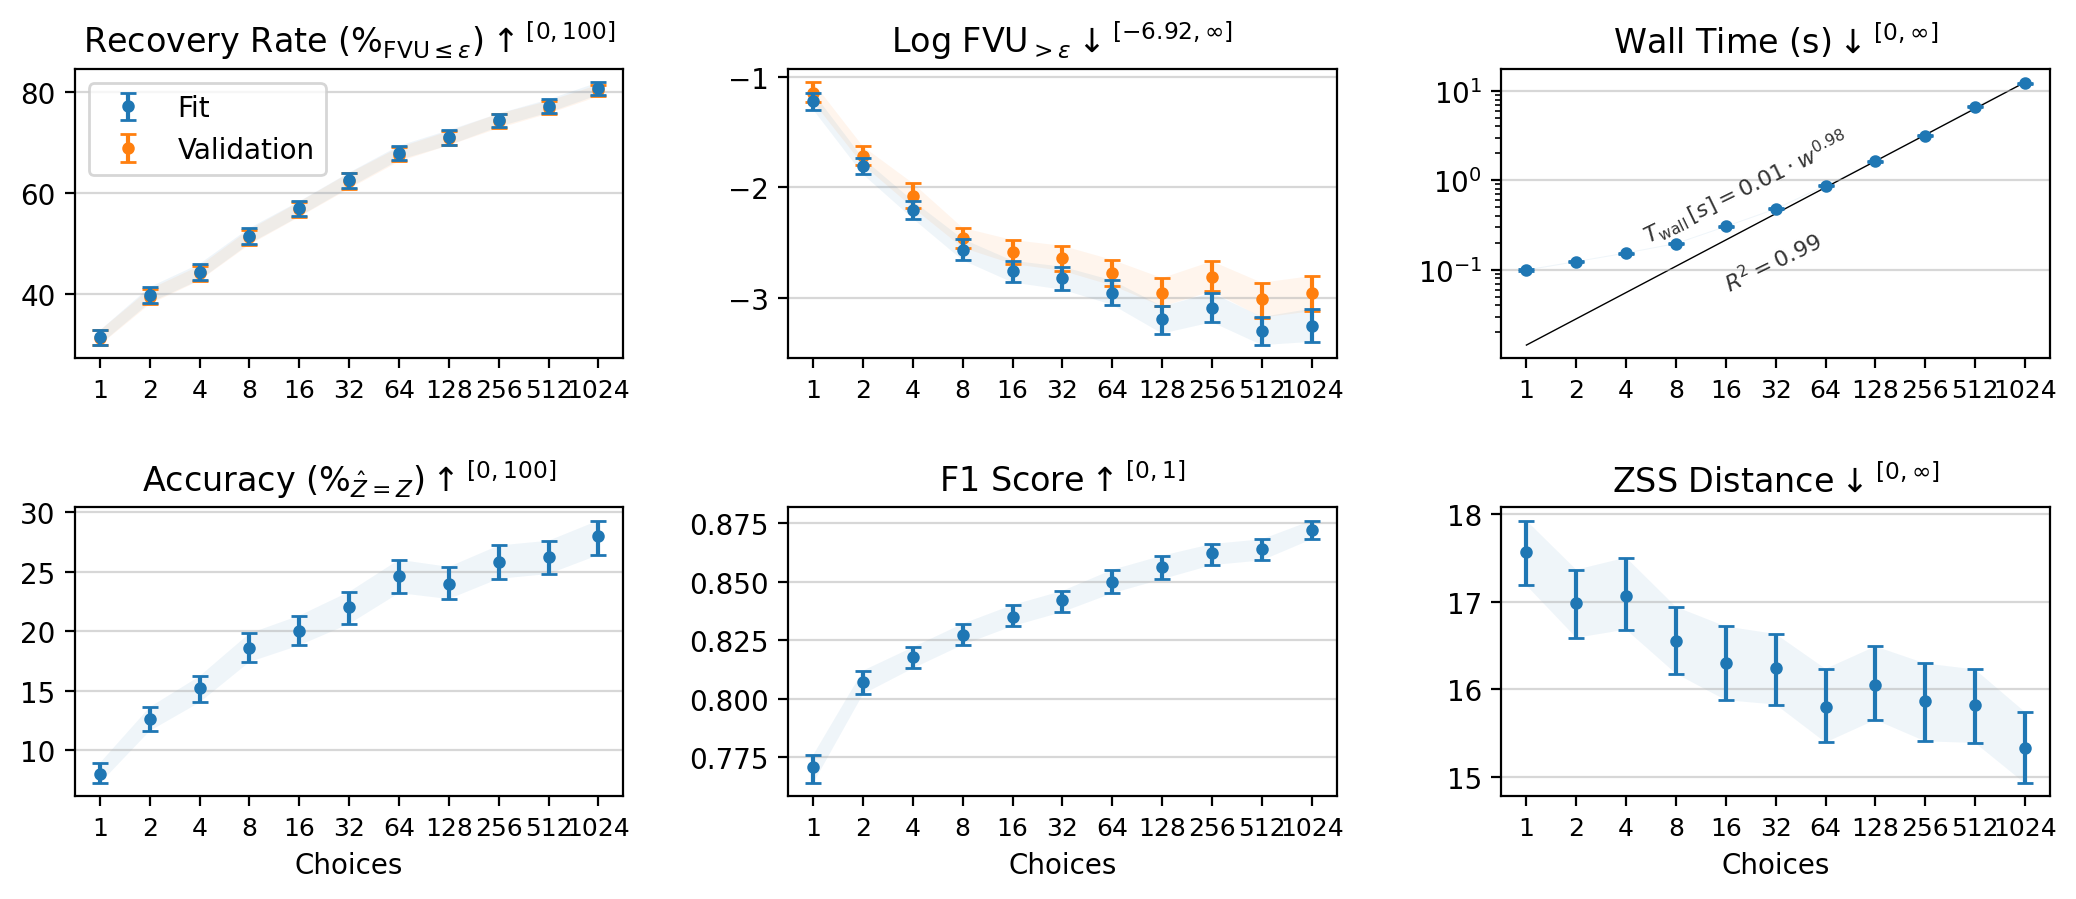

In [68]:
show_metric_list = ['FVU-eps_accuracy', 'log_fvu_not_epsilon', 'wall_time', 'accuracy_best_beam', 'f1_score_best_beam', 'tree_edit_distance_best_beam']
objective_list = ['max', 'min', 'min', 'max', 'max', 'min']
y_label_list = ['Recovery Rate ($\%_{\\text{FVU} \leq \\epsilon}$)', 'Log FVU$_{>\\epsilon}$', 'Wall Time (s)', 'Accuracy ($\%_{\hat{Z} = Z}$)', 'F1 Score', 'ZSS Distance']
bounds_list = [(0, 100), (np.log10(np.finfo(np.float32).eps).round(2), None), (0, None), (0, 100), (0, 1), (0, None)]
sub_metric_list = ['mean', 'mean', 'mean', 'mean', 'mean', 'mean']
factor_list = [100, 1, 1, 100, 1, 1]
yscale_list = ['linear', 'linear', 'log', 'linear', 'linear', 'linear']
# ylim_list = [(0, 100), (np.log10(np.finfo(np.float32).eps), None), (0, None), (0, 1), (0, None)]
ylim_list = [None] * len(show_metric_list)

x = [configs[model]['generation_config']['choices'] for model in MODELS]

COLS = min(3, len(show_metric_list))
ROWS = np.ceil(len(show_metric_list) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 3.5, ROWS * 2.3), dpi=200)

showed_val_legend = False

for i, (show_metric, sub_metric, ax, y_label, factor, ylim, objective, bounds, yscale) in enumerate(
    zip(show_metric_list, sub_metric_list, axes.flatten(), y_label_list, factor_list, ylim_list, objective_list, bounds_list, yscale_list)):

    show_metrics = [show_metric]
    if f'{show_metric}_val' in total_summary_tables[sub_metric]['median'].T.index:
        show_metrics.append(f'{show_metric}_val')
    
    for k, (s, label) in enumerate(zip(show_metrics, ['Fit', 'Validation'])):
        y = total_summary_tables[sub_metric]['median'].T.loc[s] * factor
        y_lower = total_summary_tables[sub_metric]['lower'].T.loc[s] * factor
        y_upper = total_summary_tables[sub_metric]['upper'].T.loc[s] * factor

        ax.errorbar(x, y, yerr=[y - y_lower, y_upper - y], fmt='.', markersize=7, capsize=3, zorder=3 + len(show_metrics) - k, label=label)
        sorted_indices = np.argsort(x)
        ax.fill_between(np.array(x)[sorted_indices], np.array(y_lower)[sorted_indices], np.array(y_upper)[sorted_indices], alpha=0.07, zorder=len(show_metrics) - k)

    if not showed_val_legend:
        ax.legend(loc='upper left')
        showed_val_legend = True

    ax.set_xscale('log', base=2)
    arrow = ('$\\uparrow' if objective == 'max' else '$\\downarrow') + '^{[' + str(bounds[0]) + ', ' + (str(bounds[1]) if bounds[1] is not None else '\\infty') + ']}$'
    ax.set_title(y_label + f'{arrow}')
    ax.set_xticks(x)
    ax.set_xticklabels(x, fontsize=9)

    if i // COLS == ROWS - 1:
        ax.set_xlabel('Choices')

    if show_metric == 'wall_time':
        x_logspace = np.logspace(np.log2(min(x)), np.log2(max(x)), 100, base=2)
        y_fit = np.exp(linear(np.log(x_logspace), *popt))
        ax.plot(x_logspace, y_fit, color='black', linewidth=0.5, label='Fit', zorder=1, alpha=1)
        ax.annotate(f'$T_{{\\text{{wall}}}}\,[s] = {popt[0]:.2f} \\cdot w^{{{popt[1]:.2f}}}$', (0.25, 0.4), xycoords='axes fraction', fontsize=8, rotation=26, alpha=0.8)
        ax.annotate(f'$R^2 = {1- fit_fvu:.2f}$', (0.4, 0.23), xycoords='axes fraction', fontsize=8, rotation=26, alpha=0.8)

    ax.grid(alpha=0.5, axis='y', zorder=2)

    ax.set_yscale(yscale)

    ax.set_ylim(ylim)

for ax in axes.flatten()[len(show_metric_list):]:
    ax.axis('off')

fig.tight_layout(w_pad=2, h_pad=2)

plt.savefig(get_path('results', 'analysis_choices', create=True, filename='analysis_choices_errorbars.svg'))

In [52]:
sub_metrics = ['mean', 'median', '2.5p', '97.5p']
sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]

total_summary_lengths = {length: {model: {column: {k: (np.nan, ) * 3 for k in sub_metrics} for column in compare_columns} for model in array_dfs.keys()} for length in range(32)}
aggregate_sets = ['feynman', 'soose_nc', 'nguyen', 'pool_15']
metrics = None

N_BOOTSTRAPS = 100

for model, model_dfs in array_dfs.items():
    if len(model_dfs) == 0:
        continue
    aggregated_data_lengths = {length: pd.concat([df[df['length_target'] == length] for test_set, df in model_dfs.items() if test_set in aggregate_sets]) for length in range(32)}

    for length in tqdm(range(32)):
        for column in compare_columns:
            if column in aggregated_data_lengths[length].columns:
                data = aggregated_data_lengths[length][column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
                total_summary_lengths[length][model][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}

    if metrics is None:
        metrics = total_summary_lengths[length][model][column].keys()

  0%|          | 0/32 [00:00<?, ?it/s]

/tmp/ipykernel_25621/3880369273.py:2: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.array(x)[np.isfinite(x)])
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1649: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  9%|▉         | 3/32 [00:00<00:05,  5.27it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_shape_base_impl.py:393: RuntimeWarning: All-NaN slice encountered
  res = asanyarray(func1d(inarr_view[ind0], *args, **kwargs))
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_shape_base_impl.py:416: RuntimeWarning: All-NaN slice encountered
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))
/h

KeyboardInterrupt: 

In [50]:
total_summary_tables_length = {
    length: {
        metric: {
            percentile:
                pd.DataFrame({
                model: {
                    column: total_summary_lengths[length][model][column][metric][k]
                    for column in compare_columns}
                    for model in total_summary.keys()}).T.round(3)
                    for k, percentile in enumerate(['median', 'lower', 'upper'])}
                    for metric in metrics}
                    for length in range(32)}

In [51]:
from matplotlib.colors import LogNorm

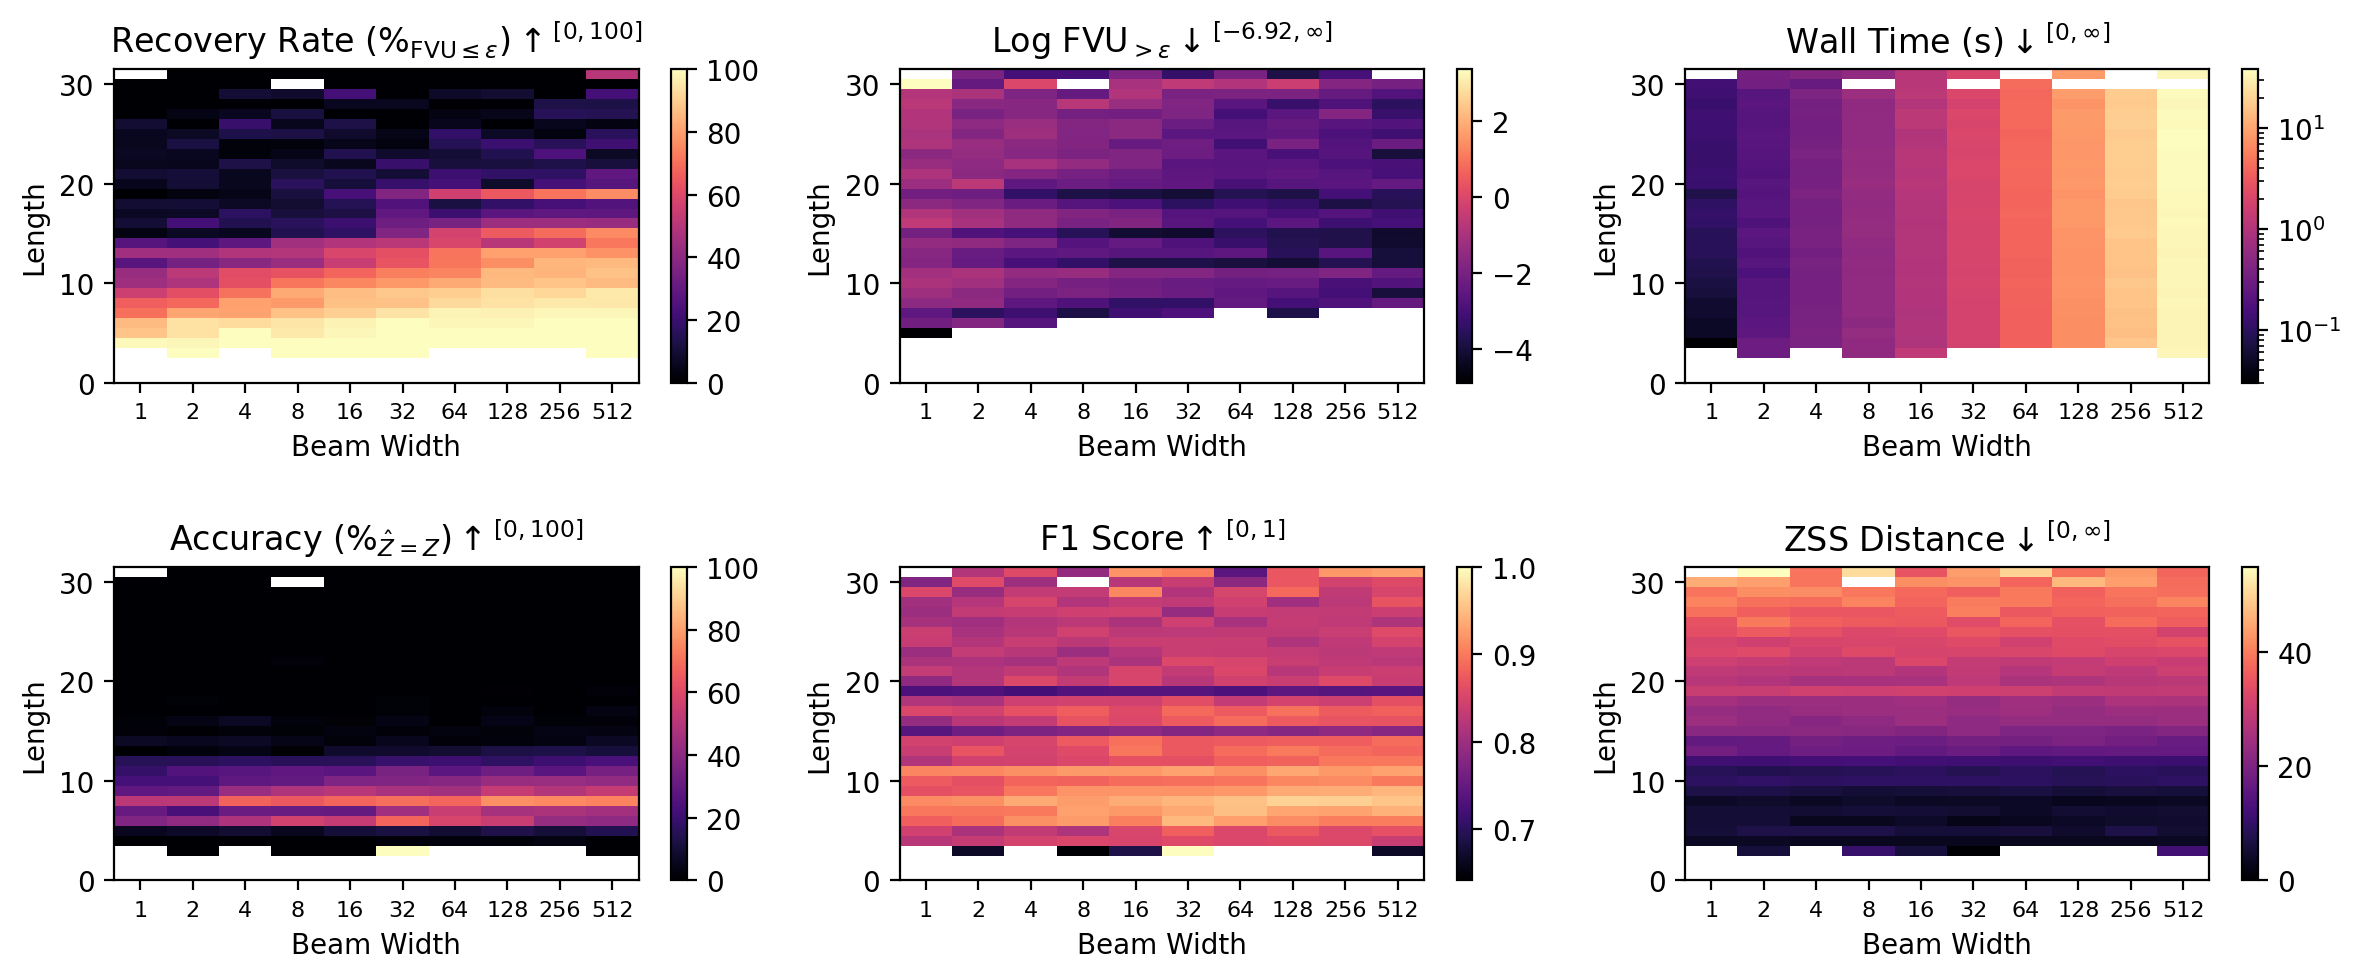

In [52]:
show_metric_list = ['FVU-eps_accuracy', 'log_fvu_not_epsilon', 'wall_time', 'accuracy_best_beam', 'f1_score_best_beam', 'tree_edit_distance_best_beam']
objective_list = ['max', 'min', 'min', 'max', 'max', 'min']
y_label_list = ['Recovery Rate ($\%_{\\text{FVU} \leq \\epsilon}$)', 'Log FVU$_{>\\epsilon}$', 'Wall Time (s)', 'Accuracy ($\%_{\hat{Z} = Z}$)', 'F1 Score', 'ZSS Distance']
bounds_list = [(0, 100), (np.log10(np.finfo(np.float32).eps).round(2), None), (0, None), (0, 100), (0, 1), (0, None)]
sub_metric_list = ['mean', 'mean', 'mean', 'mean', 'mean', 'mean']
factor_list = [100, 1, 1, 100, 1, 1]
log_norm_list = [False, False, True, False, False, False]
ylim_list = [(0, 31.5)] * len(show_metric_list)

x = np.array([configs[model]['beam_width'] for model in MODELS])
sorted_indices = np.argsort(x)

COLS = min(3, len(show_metric_list))
ROWS = np.ceil(len(show_metric_list) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 4, ROWS * 2.5), dpi=200)

for i, (show_metric, sub_metric, ax, y_label, factor, ylim, log_norm, bounds, objective) in enumerate(
    zip(show_metric_list, sub_metric_list, axes.flatten(), y_label_list, factor_list, ylim_list, log_norm_list, bounds_list, objective_list)):
    y = np.array([s[sub_metric]['median'].T.loc[show_metric] for s in total_summary_tables_length.values()]) * factor

    mesh = np.meshgrid(np.log2(x[sorted_indices]), np.arange(32))
    colormesh = ax.pcolormesh(mesh[0], mesh[1], y[:, sorted_indices], shading='auto', cmap='magma', norm=LogNorm() if log_norm else None, linewidth=0, rasterized=True)
    # colormesh.set_edgecolor('face')


    ax.set_xticks(np.log2(x))
    ax.set_xticklabels(x, fontsize=8)

    ax.set_ylabel('Length')
    ax.set_xlabel('Beam Width')
    arrow = ('$\\uparrow' if objective == 'max' else '$\\downarrow') + '^{[' + str(bounds[0]) + ', ' + (str(bounds[1]) if bounds[1] is not None else '\\infty') + ']}$'
    ax.set_title(y_label + f'{arrow}')
    
    # Add a little colorbar to each plot
    cb = plt.colorbar(colormesh, ax=ax)

    ax.set_ylim(ylim)

# hist_x = np.arange(32)
# hist_y = [len(aggregated_data_lengths[length]) for length in range(32)]

# hist_plot_x = np.empty(2 * len(hist_x))
# hist_plot_x[0::2] = hist_x - 0.5
# hist_plot_x[1::2] = hist_x + 0.5
# hist_plot_y = np.empty(2 * len(hist_y))
# hist_plot_y[0::2] = hist_y
# hist_plot_y[1::2] = hist_y

# axes.flatten()[-1].fill_betweenx(hist_plot_x, hist_plot_y, color='k', alpha=0.2)
# axes.flatten()[-1].set_xlim(0, None)
# axes.flatten()[-1].set_xlabel('Number of Test Equations')
# axes.flatten()[-1].set_ylabel('Length')
# axes.flatten()[-1].grid(alpha=0.5)
# axes.flatten()[-1].set_ylim(0, 32)
# axes.flatten()[-1].set_title('Aggregated Test Set Distribution')

# Add a phantom colorbar
# cb = plt.colorbar(colormesh, ax=axes.flatten()[-1])
# Hide the colorbar
# cb.ax.set_visible(False)

fig.tight_layout(w_pad=1, h_pad=2)

plt.savefig(get_path('results', 'analysis_beams', create=True, filename='analysis_beams_length_heatmap.svg'))